In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
import networkx as nx
from grave import plot_network

from collections import deque
import itertools
import random

from debruijnal_enhance_o_tron.sequence import kmers
from screed import ScreedDB, make_db

#from fa2 import ForceAtlas2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from ficus import FigureManager
from IPython.display import FileLink

In [5]:
from boink.dbg import make_dBG
from boink.cdbg import UnitigNodeView, DecisionNodeView
from boink.compactor import make_streaming_compactor
#from boink.reporting import cDBGHistoryReporter

In [6]:
sns.set(style="ticks")

In [4]:
make_db('A_xenica_ONT_testreads.fasta')
ONT_reads = ScreedDB('A_xenica_ONT_testreads.fasta')

In [5]:
#graph = make_dBG(27, 1e8, 4, storage='_SparseppSetStorage')
#compactor = make_streaming_compactor(graph)
#history = cDBGHistoryReporter('err_seq.history.graphml')
#compactor.cdbg.Notifier.register_listener(history)
#compactor.update_sequence(str(ONT_reads.items()[0][1].sequence))
#compactor.update_sequence(str(ONT_reads.items()[1][1].sequence))
#compactor.update_sequence(str(ONT_reads.items()[2][1].sequence))
#compactor.update_sequence(str(ONT_reads.items()[3][1].sequence))
#compactor.update_sequence(str(ONT_reads.items()[4][1].sequence))
#for n, (name, record) in enumerate(ONT_reads.items()):
#    compactor.update_sequence(str(record.sequence))
#    if n > 10:
#        break

In [7]:
def to_networkx(cdbg, abunds=None):
    G = nx.DiGraph()
    for dnode in cdbg.dnodes():
        G.add_node(dnode.node_id, sequence=dnode.sequence,
                   node_id=dnode.node_id, kind='decision')
        
    for dnode in cdbg.dnodes():
        lneighbors, rneighbors = cdbg.find_dnode_neighbors(dnode)
        for neighbor in lneighbors:
            if isinstance(neighbor, DecisionNodeView):
                G.add_edge(neighbor.node_id, dnode.node_id)
        for neighbor in rneighbors:
            if isinstance(neighbor, DecisionNodeView):
                G.add_edge(dnode.node_id, neighbor.node_id)
        
    for unode in cdbg.unodes():
        G.add_node(unode.node_id, sequence=unode.sequence,
                   node_id=unode.node_id, kind='unitig', meta=unode.meta)
        lneighbor, rneighbor = cdbg.find_unode_neighbors(unode)
        if lneighbor is not None:
            G.add_edge(lneighbor.node_id, unode.node_id)
        if rneighbor is not None:
            G.add_edge(unode.node_id, rneighbor.node_id)
    return G

In [8]:
def fa2_layout(outboundAttractionDistribution=False,
               edgeWeightInfluence=1.0,
               jitterTolerance=1.0,
               barnesHutOptimize=True,
               barnesHutTheta=1.2,
               scalingRatio=2.0,
               strongGravityMode=False,
               gravity=1.0,
               iterations=2000,
               pos=None,
               verbose=True):
    
    def layout(G):

        forceatlas2 = ForceAtlas2(# Behavior alternatives
                                  outboundAttractionDistribution=outboundAttractionDistribution,  # Dissuade hubs
                                  edgeWeightInfluence=edgeWeightInfluence,
                                  # Performance
                                  jitterTolerance=jitterTolerance,  # Tolerance
                                  barnesHutOptimize=barnesHutOptimize,
                                  barnesHutTheta=barnesHutTheta,
                                  # Tuning
                                  scalingRatio=scalingRatio,
                                  strongGravityMode=strongGravityMode,
                                  gravity=gravity,
                                  # Log
                                  verbose=verbose)

        positions = forceatlas2.forceatlas2_networkx_layout(G, pos=pos, iterations=iterations)
        return positions
    
    return layout

In [9]:
def plot_cdbg(cdbg, sequence_label=None, new=None, debug=False, ax=None, layout='kamada_kawai'):

    def font_styler(attributes):
        return {'font_size': 8,
                'font_weight': .5}

    def color_dnodes(node_attrs):
        style = {'size': 100}
        if node_attrs.get('kind') == 'decision':
            style['color'] = 'red'
        else:
            style ['color'] = 'black'  

        return style
    
    def color_new(is_new):
        def _color(node_attrs):
            style = color_dnodes(node_attrs)
            style['width'] = 2.0
            if node_attrs['node_id'] in new:
                style['edgecolor'] = 'blue'
            else:
                style['edgecolor'] = 'black'
            
            return style
        return _color
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
        
    plot_network(cdbg, ax=ax,
                 node_style=color_dnodes if new is None else color_new(new),
                 #node_label_style=font_styler,
                 layout=layout)
    return ax

In [10]:
def compactify_iterative(reads_db, limit=2, layout='kamada_kawai'):
    graph = make_dBG(27, 1e8, 4, storage='_SparseppSetStorage')
    tracking = make_dBG(27, 1e8, 4, storage='_SparseppSetStorage')
    cptor = make_streaming_compactor(graph)
    
    existing = set()
    fig, axes = plt.subplots(nrows=limit, ncols=1, figsize=(8, 8 * limit))
    for n, (idx, record) in enumerate(reads_db.items()):
        if n == limit:
            break
        print('Adding', record.name, 'with', len(record.sequence), 'bases.')
        _, is_new = tracking.add_sequence_and_report(str(record.sequence))
        print(sum(is_new), 'new k-mers')
        
        #cptor = make_streaming_compactor(make_dBG(27, 1e8, 4, storage='_SparseppSetStorage'))
        #cptor.update_sequence(str(record.sequence))
        cptor.update_sequence(str(record.sequence))
        
        new = set()
        for node in itertools.chain(cptor.cdbg.dnodes(), cptor.cdbg.unodes()):
            if node.node_id not in existing:
                new.add(node.node_id)
            existing.add(node.node_id)
        
        ax = axes[n]
        nxg = to_networkx(cptor.cdbg)
        plot_cdbg(nxg, layout=layout, ax=ax, new=new)
        ax.set_title('First {0}, {1} new k-mers, {2} u-nodes, {3} d-nodes, {4} components'.format(n,
                                                                                  sum(is_new),
                                                                                  cptor.cdbg.n_unodes,
                                                                                  cptor.cdbg.n_dnodes,
                                                                                  nx.number_weakly_connected_components(nxg)))
        print(cptor.cdbg.n_dnodes, cptor.cdbg.n_unodes)
    
    return cptor, fig, axes

 72%|███████▏  | 1445/2000 [00:00<00:00, 14441.47it/s]

Adding A_xenica_PromethION-9a58cf3a-cbde-412f-a4e7-318a0be0c90b with 16746 bases.
16562 new k-mers


  0%|          | 0/2000 [00:00<?, ?it/s]

BarnesHut Approximation  took  0.04  seconds
Repulsion forces  took  0.04  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds
BarnesHut Approximation  took  0.04  seconds
Repulsion forces  took  0.05  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds
13 14
Adding A_xenica_PromethION-c55478f5-144d-4821-9a23-49aa12224b8c with 25531 bases.
25402 new k-mers


 33%|███▎      | 669/2000 [00:00<00:00, 6688.51it/s]

BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.12  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


 32%|███▏      | 641/2000 [00:00<00:00, 6401.11it/s]

BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.13  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds
28 24
Adding A_xenica_PromethION-c6db3e59-a612-402e-a7ea-9abdab55c793 with 7164 bases.
7128 new k-mers


 32%|███▏      | 637/2000 [00:00<00:00, 6366.99it/s]

BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.14  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 28%|██▊       | 566/2000 [00:00<00:00, 5659.63it/s]

BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.15  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
29 27
Adding A_xenica_PromethION-69d9eccb-b5fd-4a79-8191-477e23cf57dd with 3034 bases.
3008 new k-mers


 29%|██▉       | 579/2000 [00:00<00:00, 5781.17it/s]

BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.17  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 31%|███       | 621/2000 [00:00<00:00, 6200.90it/s]

BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.16  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
29 28
Adding A_xenica_PromethION-df731f3f-1965-455f-bb75-5a6a645f4edc with 4199 bases.
4173 new k-mers


 28%|██▊       | 552/2000 [00:00<00:00, 5512.66it/s]

BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.13  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 29%|██▉       | 576/2000 [00:00<00:00, 5750.74it/s]

BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.17  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
29 29
Adding A_xenica_PromethION-3ee7b7ff-9007-477f-98a3-34ccb90f65c7 with 6268 bases.
6242 new k-mers


 27%|██▋       | 546/2000 [00:00<00:00, 5458.95it/s]

BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.17  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 26%|██▌       | 518/2000 [00:00<00:00, 5176.08it/s]

BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.15  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
29 30
Adding A_xenica_PromethION-e0788920-bfb2-4434-830c-d9a858ae12cd with 4332 bases.
4303 new k-mers


 26%|██▌       | 522/2000 [00:00<00:00, 5217.18it/s]

BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.18  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 23%|██▎       | 456/2000 [00:00<00:00, 4559.31it/s]

BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.18  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
31 34
Adding A_xenica_PromethION-a13b328d-d2fa-4a7c-8ae7-dd3a3676d036 with 5782 bases.
5752 new k-mers


 23%|██▎       | 460/2000 [00:00<00:00, 4593.54it/s]

BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.23  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 24%|██▍       | 475/2000 [00:00<00:00, 4743.89it/s]

BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.21  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
35 35
Adding A_xenica_PromethION-07098024-c8d0-4f8d-b2d4-187d422347bc with 7185 bases.
7159 new k-mers


 22%|██▏       | 433/2000 [00:00<00:00, 4325.29it/s]

BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.20  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


 22%|██▏       | 447/2000 [00:00<00:00, 4464.08it/s]

BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.24  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds
35 36
Adding A_xenica_PromethION-4e861a6e-8b85-451e-8ec7-8348d68d49bd with 4674 bases.
4648 new k-mers


 22%|██▏       | 438/2000 [00:00<00:00, 4377.25it/s]

BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.22  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


100%|██████████| 2000/2000 [00:00<00:00, 4301.06it/s]


BarnesHut Approximation  took  0.12  seconds
Repulsion forces  took  0.23  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds
35 37


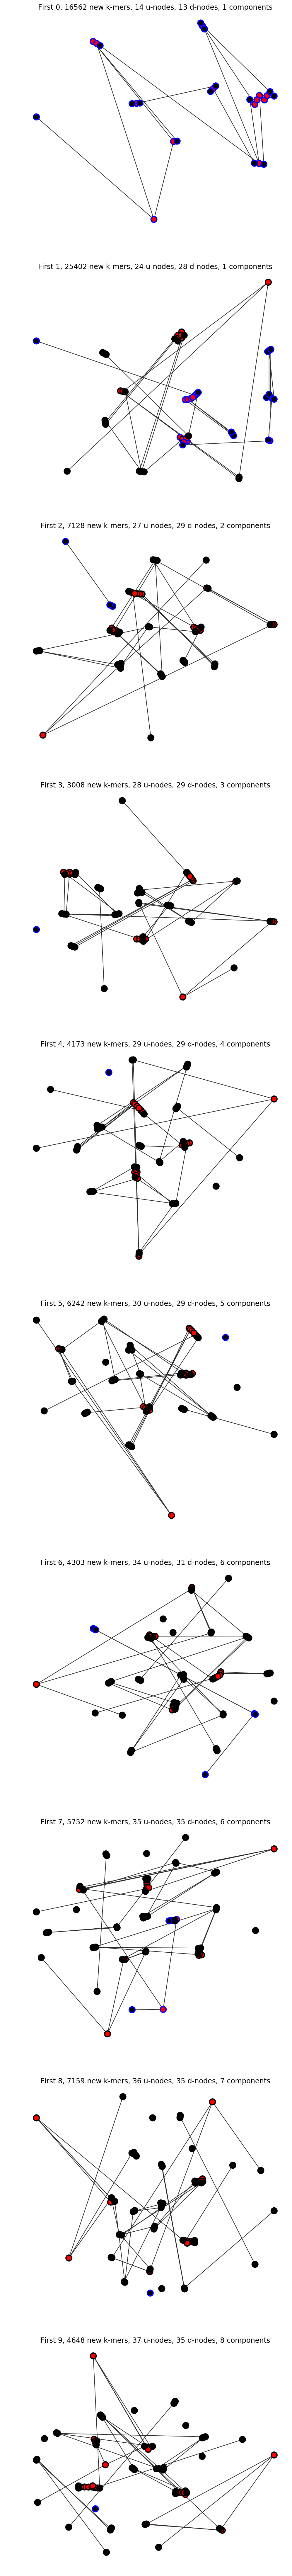

In [10]:
layout = fa2_layout(gravity=.5)
cptor, fig, axes = compactify_iterative(ONT_reads, layout=layout, limit=10)

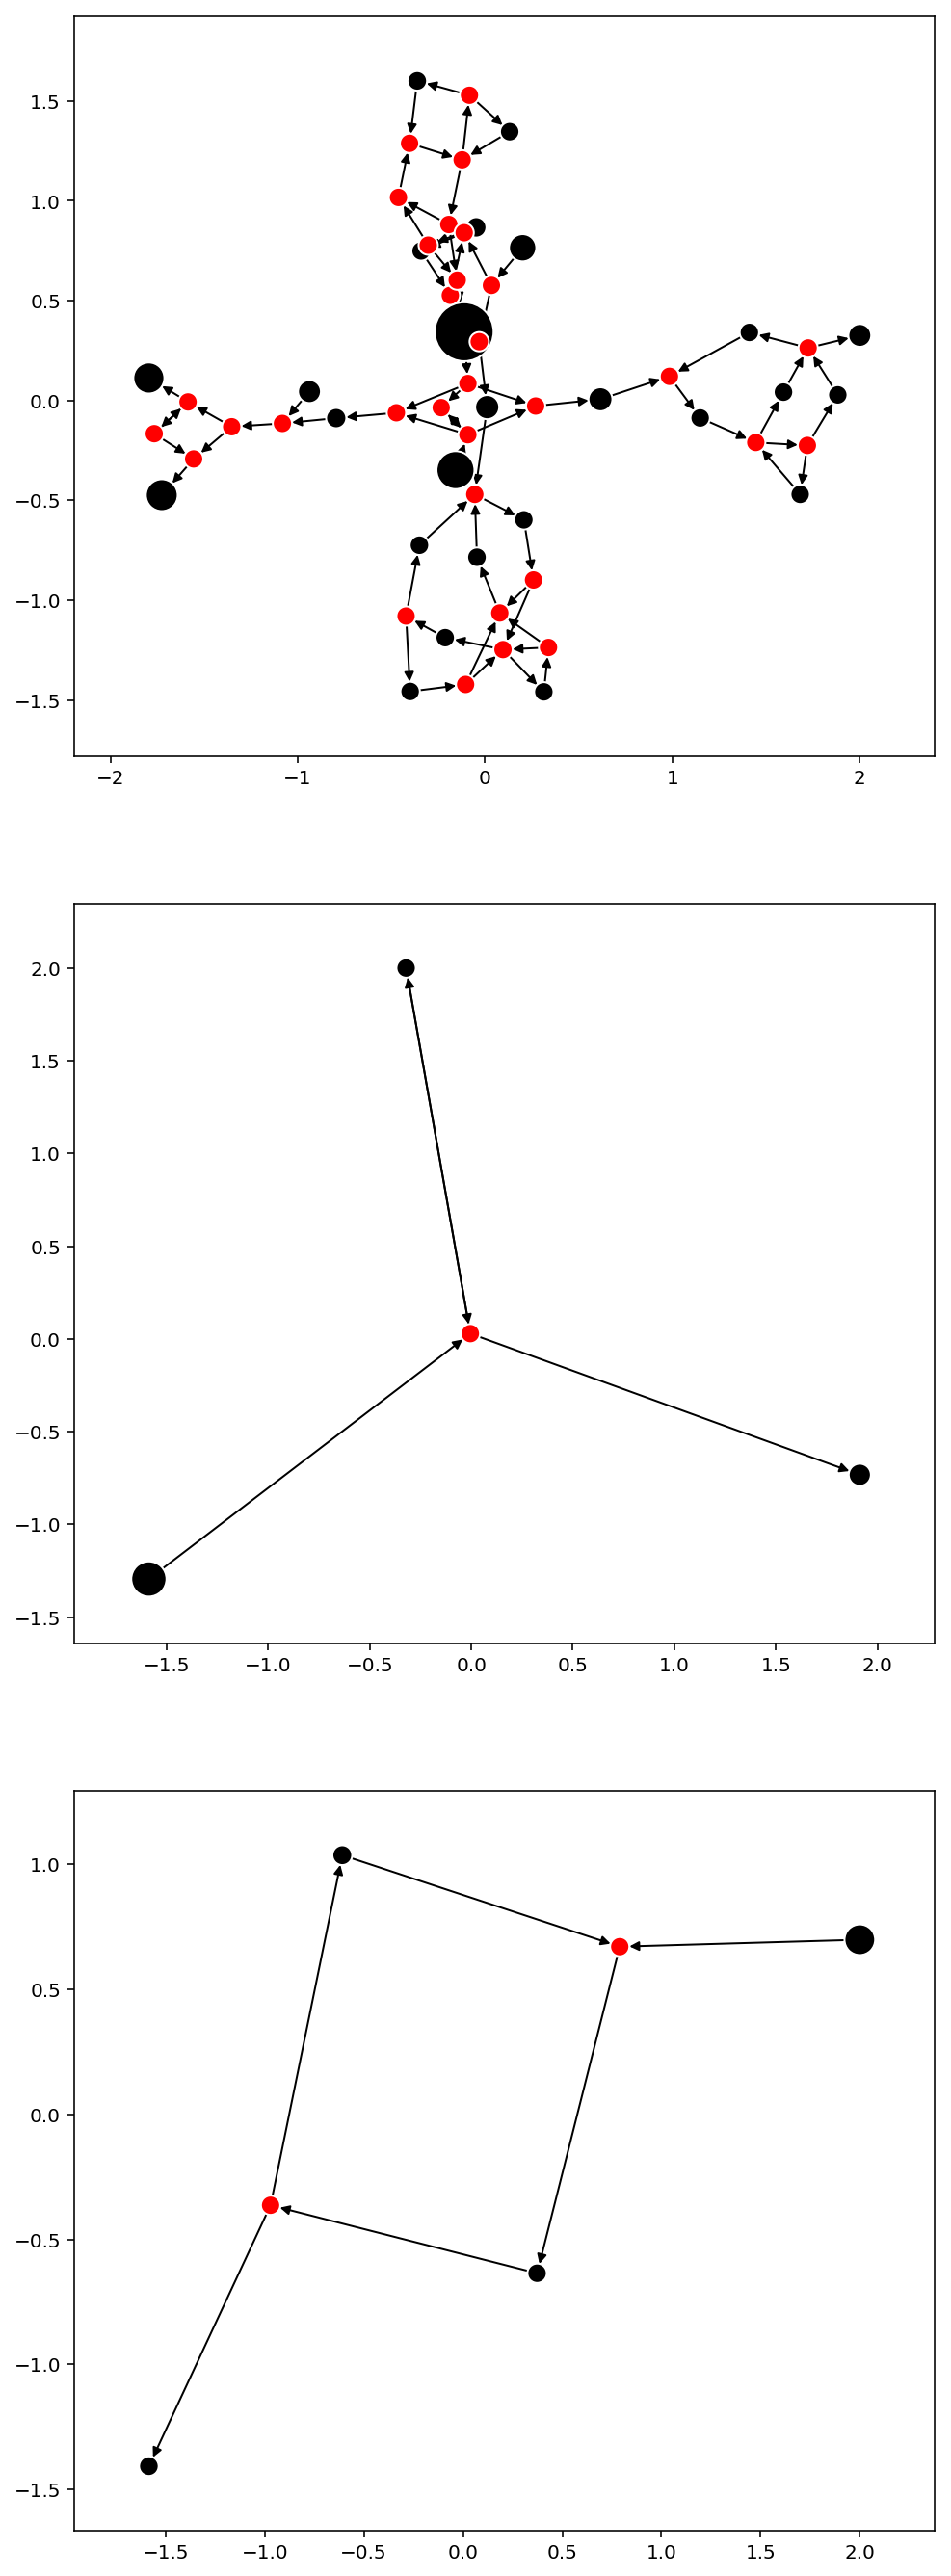

In [39]:
nxg = to_networkx(cptor.cdbg)
subgraphs = [nxg.subgraph(c).copy() for c in nx.weakly_connected_components(nxg) if len(c) > 1]
fig, axes = plt.subplots(nrows=len(subgraphs), ncols=1, figsize=(8, 8 * len(subgraphs)))

for subgraph, ax in zip(subgraphs, axes):
    init_positions = nx.spring_layout(subgraph)
    positions = nx.kamada_kawai_layout(subgraph, scale=2, pos=init_positions)

    color = lambda attrs: 'red' if attrs['kind'] == 'decision' else 'black'

    sizes = []
    for node, node_attrs in subgraph.nodes.data():
        if node_attrs.get('kind') == 'unitig':
            sizes.append(100 + len(node_attrs.get('sequence')) / 27)
        else:
            sizes.append(100)

    nx.draw_networkx(subgraph, 
                     positions,
                     node_color=[color(attrs) for n, attrs in subgraph.nodes.data()],
                     node_size=sizes,
                     edgecolors='white',
                     linewidths=1.0,
                     with_labels=False,
                     ax=ax)
#plot_cdbg(nxg, layout=layout, ax=ax)

In [ ]:
nx.write_gml(to_networkx(cptor.cdbg), 'A_xenica_15.gml')

In [105]:
fig.savefig('A_xenica_first_15_iterative_spring.png', dpi=300)

In [37]:
cptor.cdbg.save('A_xenica.first10.gfa1', 'gfa1')

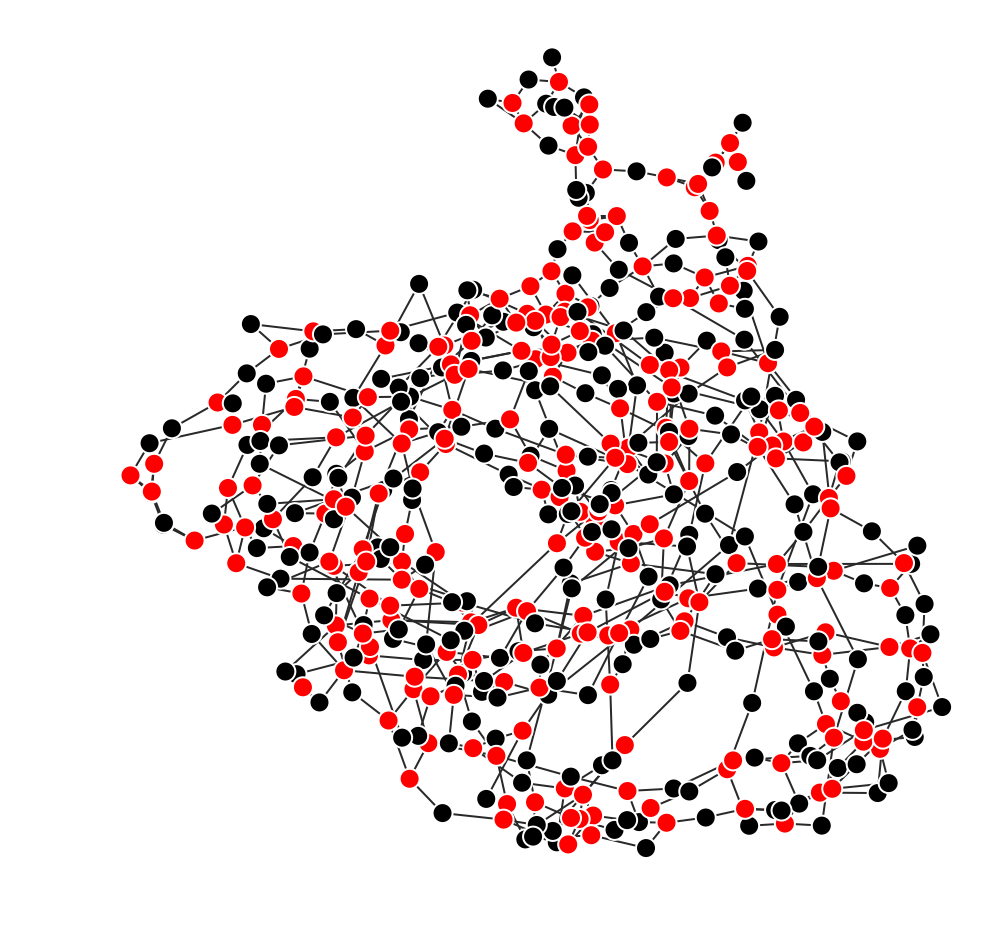

In [70]:
nxg = to_networkx(compactor.cdbg)
plot_cdbg(nxg)

In [72]:
nx.write_gml(nxg, 'A_xenica.gml')

In [12]:
import screed

In [26]:
graph = make_dBG(25, 1e8, 4, storage='_SparseppSetStorage')
cptor = make_streaming_compactor(graph)
for record in screed.open('F_diaphanus_TRINITY_DN28_cluster.fasta'):
    cptor.update_sequence(record.sequence)
nxg = to_networkx(cptor.cdbg)

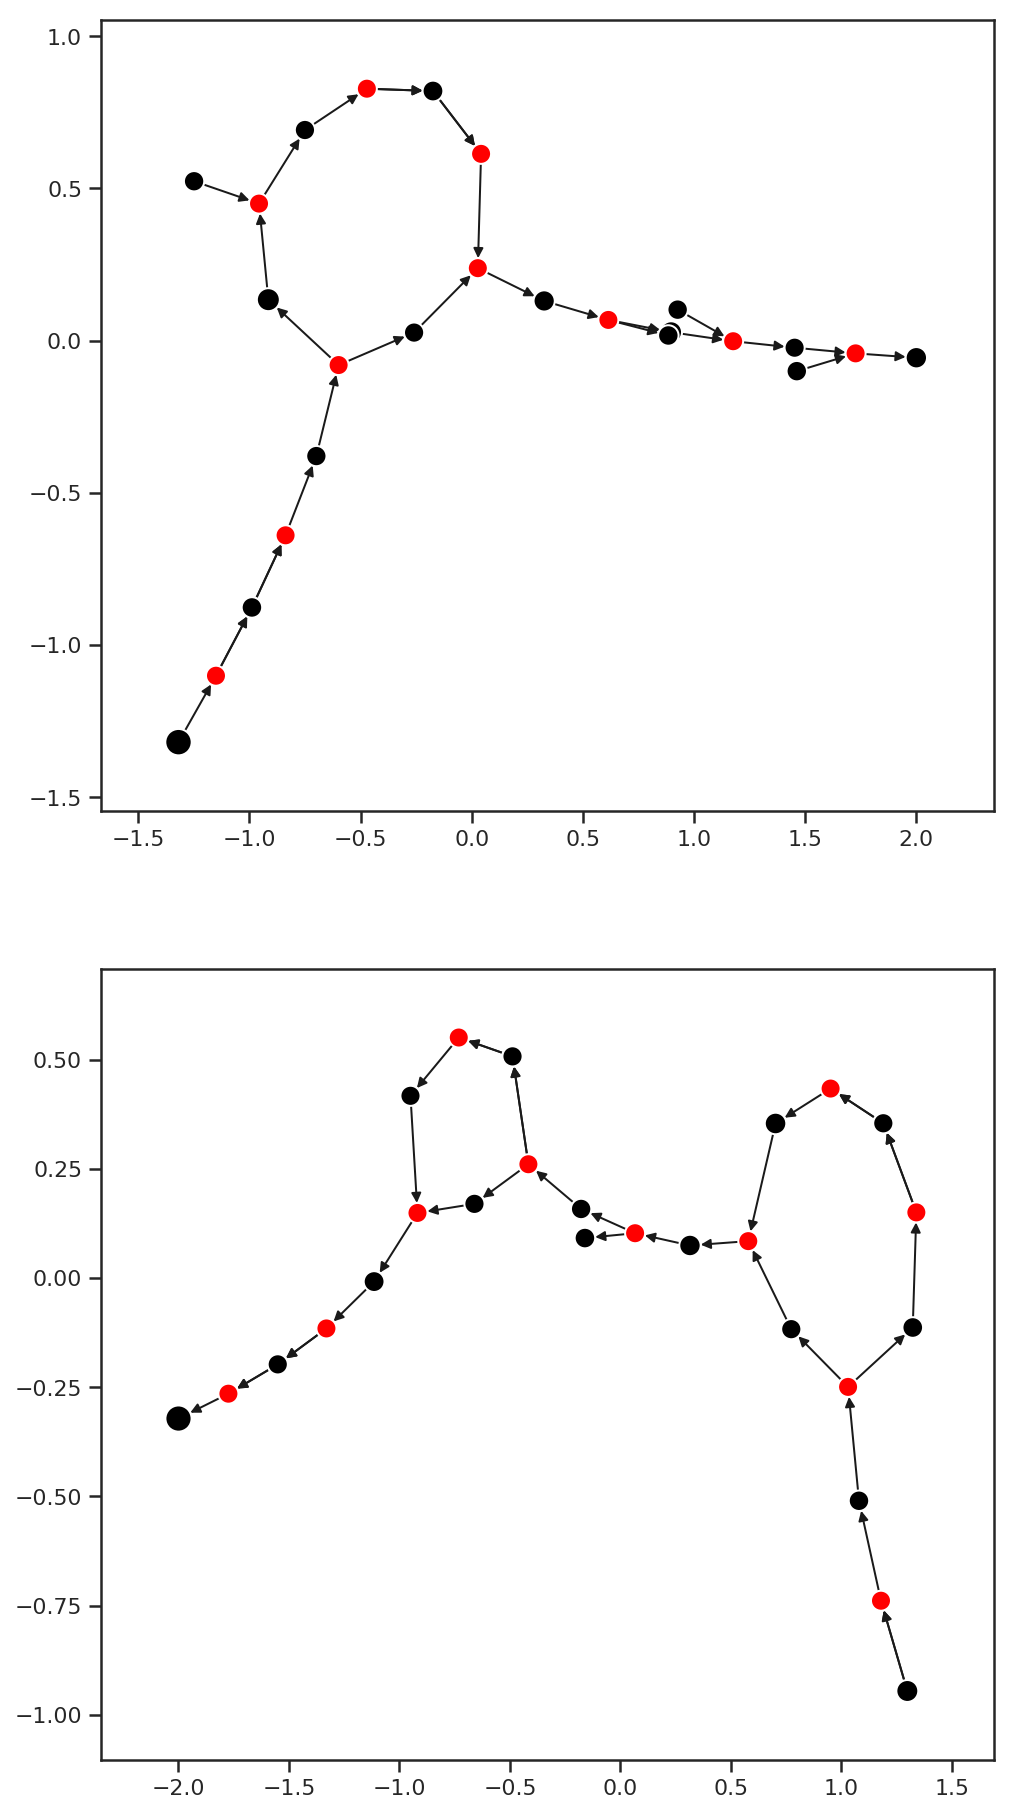

In [27]:
subgraphs = [nxg.subgraph(c).copy() for c in nx.weakly_connected_components(nxg) if len(c) > 1]
with FigureManager(show=True, filename='F_diaphanus_TRINITY_DN28_cluster.png',
                   nrows=len(subgraphs), ncols=1, figsize=(8, 8 * len(subgraphs))) as (fig, axes):

    for subgraph, ax in zip(subgraphs, axes):
        init_positions = nx.spring_layout(subgraph)
        positions = nx.kamada_kawai_layout(subgraph, scale=2, pos=init_positions)

        color = lambda attrs: 'red' if attrs['kind'] == 'decision' else 'black'

        sizes = []
        for node, node_attrs in subgraph.nodes.data():
            if node_attrs.get('kind') == 'unitig':
                sizes.append(100 + len(node_attrs.get('sequence')) / 27)
            else:
                sizes.append(100)

        nx.draw_networkx(subgraph, 
                         positions,
                         node_color=[color(attrs) for n, attrs in subgraph.nodes.data()],
                         node_size=sizes,
                         edgecolors='white',
                         linewidths=1.0,
                         with_labels=False,
                         ax=ax)

nxg = to_networkx(cptor.cdbg)
#subgraphs = [nxg.subgraph(c).copy() for c in nx.weakly_connected_components(nxg) if len(c) > 1]
#nxg = subgraphs[0]

with FigureManager(show=True, filename='F_diaphanus_TRINITY_DN28_cluster.png') as (fig, ax):
    init_positions = nx.spring_layout(nxg)
    positions = nx.kamada_kawai_layout(nxg, scale=2, pos=init_positions)

    color = lambda attrs: 'red' if attrs['kind'] == 'decision' else 'black'

    sizes = []
    for node, node_attrs in nxg.nodes.data():
        if node_attrs.get('kind') == 'unitig':
            sizes.append(100 + len(node_attrs.get('sequence')) / 25)
        else:
            sizes.append(100)

    nx.draw_networkx(nxg, 
                     positions,
                     node_color=[color(attrs) for n, attrs in nxg.nodes.data()],
                     node_size=sizes,
                     edgecolors='white',
                     linewidths=1.0,
                     with_labels=False,
                     ax=ax)

## Dynamic cDBG Metrics

The following figures demonstrate some dynamic descriptive statistics on cDBGs generated by boink.

Firstly, we demonstrate on a diatom 

In [5]:
def get_cdbg_stats_data(filename):
    data = pd.read_csv(filename)
    data['t'] = data['read_n'] / data['read_n'].max()

    cdbg_cols =['n_full', 'n_tips', 'n_islands', 'n_trivial', 'n_circular']
    for col in cdbg_cols:
        data[col + '_p'] = data[col] / data['n_unodes']
    data['dnode_p'] = data['n_dnodes'] / (data['n_unodes'] + data['n_dnodes'])
    data['kmer_p'] = data['n_unique'] / data['n_unique'].max()
    prop_cols = [col + '_p' for col in cdbg_cols] + [ 'kmer_p']
    
    return data, prop_cols

In [6]:
def compute_slope(data, t):
    rise = data[1:].values - data[:-1].values
    run  = t[1:].values - t[:-1].values
    return rise / run

In [7]:
def find_slopes(data, cols):
    slopes = {}
    for col in cols:
        slope_col = 'd_{0}_dt'.format(col)
        slopes[slope_col] = compute_slope(data[col], data['t'])
    return pd.DataFrame(slopes, index=data['t'][1:])

In [8]:
def plot_proportional(stats_filename, sample_name):
    data, prop_cols = get_cdbg_stats_data(stats_filename)
    
    with FigureManager(filename=stats_filename + '.proportional.png',
                       figsize=(12,8),
                       show=True) as (fig, ax):

        cols = prop_cols + ['t']
        data[cols].plot(x='t', lw=3, ax=ax)
        ax.legend()
        ax.set_title('Dynamic cDBG Metrics for {0}'.format(sample_name))
    
    return ax

In [9]:
def plot_frequency(stats_filename, sample_name, ylim=(10,-10), lw=2, logy=False):
    data, prop_cols = get_cdbg_stats_data(stats_filename)

    with FigureManager(figsize=(12,8),
                       show=True) as (fig, ax):
        
        slopes = find_slopes(data, prop_cols)
        slopes.plot(ax=ax, lw=lw)
        
        if logy:
            ax.set_yscale('symlog')
        
        top, bottom = ylim
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_title('cDBG Observation Frequency for {0}'.format(sample_name))

    return ax

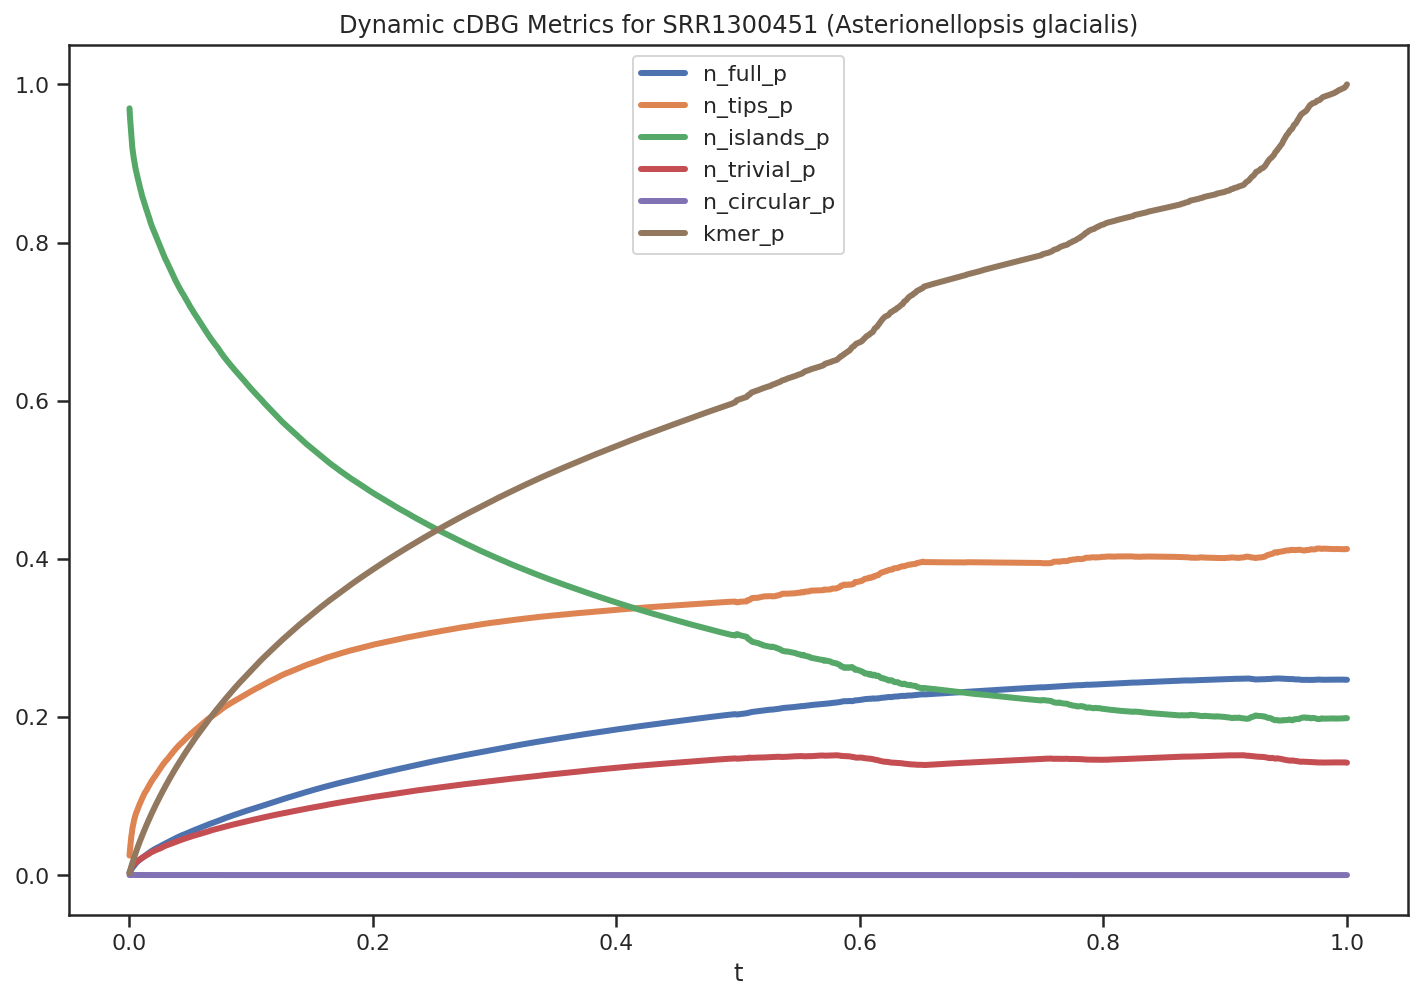

In [10]:
plot_proportional('boink.build-cdbg.SRR1300451/boink.cdbg.stats.csv', 'SRR1300451 (Asterionellopsis glacialis)')

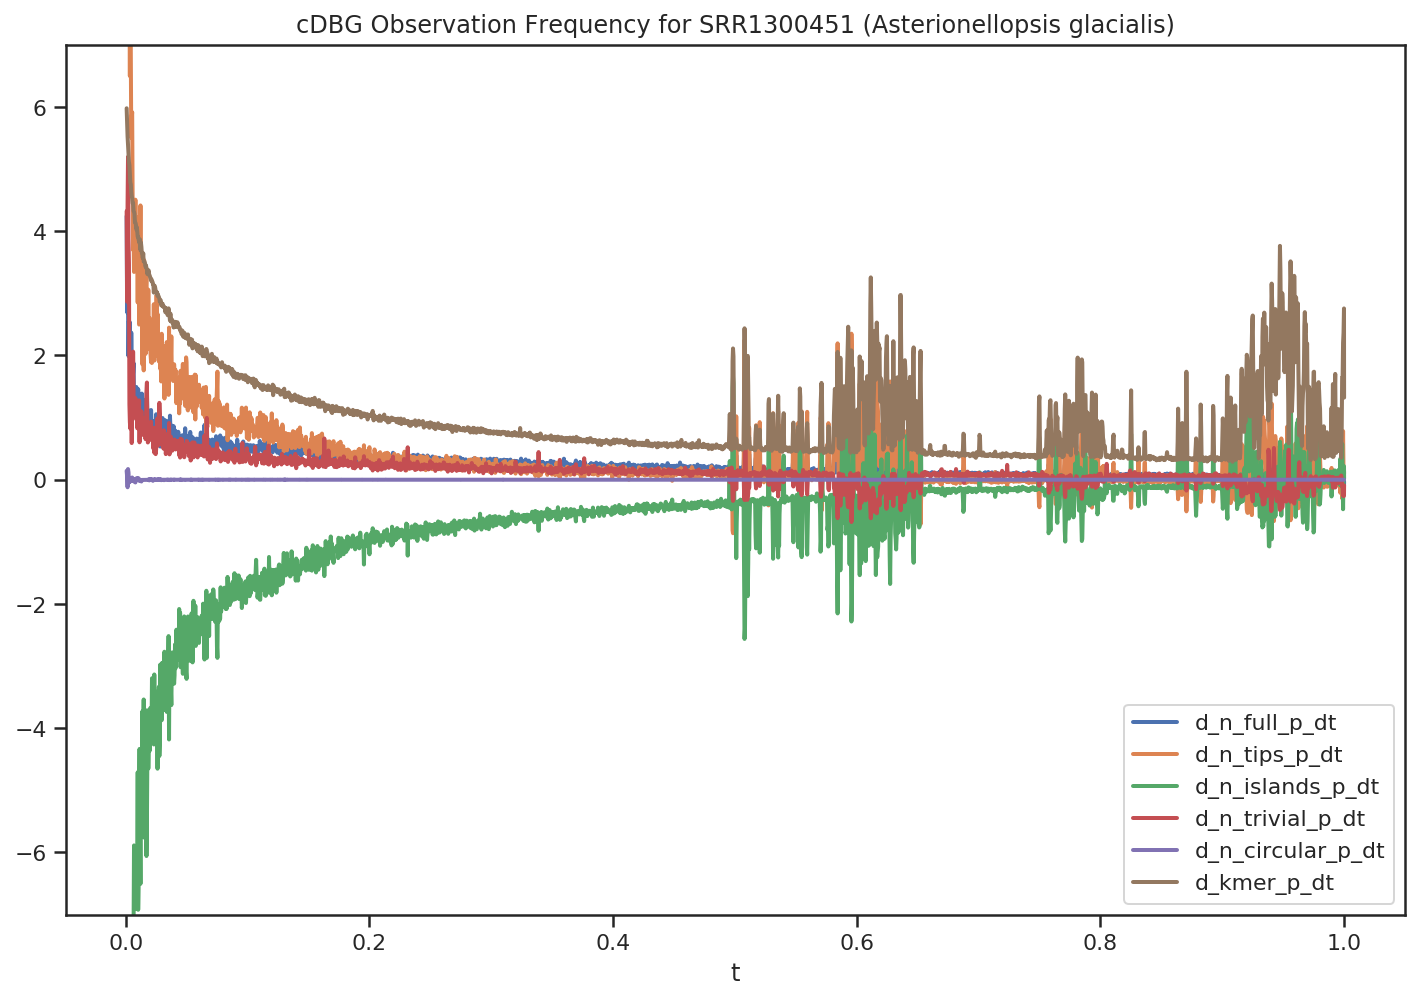

In [11]:
plot_frequency('boink.build-cdbg.SRR1300451/boink.cdbg.stats.csv', 'SRR1300451 (Asterionellopsis glacialis)', ylim=(7,-7))

In [14]:
def plot_component_size_samples(directory, interval=1000000):
    import ast

    data = pd.read_csv('{0}/boink.cdbg.components.csv'.format(directory),
                       converters={'component_size_sample': lambda col: ast.literal_eval(col)})
    data = data[:-1]
    samples = pd.DataFrame.from_items(zip(data.read_n, data.component_size_sample.values))
    
    with FigureManager('{0}/component_sizes_cumsum.png'.format(directory),
                   figsize=(12,12),
                   show=True) as (fig, ax):

        subsamples = [ t for t in list(samples.columns.unique()) if t % interval == 0 ]
        _samples = samples[subsamples]
        _samples = _samples.apply(lambda x: x.sort_values().values)
        cums = _samples.cumsum()
        sums = _samples.sum()
        (cums / sums).plot(ax=ax, colormap = cm.autumn_r)
        ax.set_title('Cumulative Component Size Proportion')

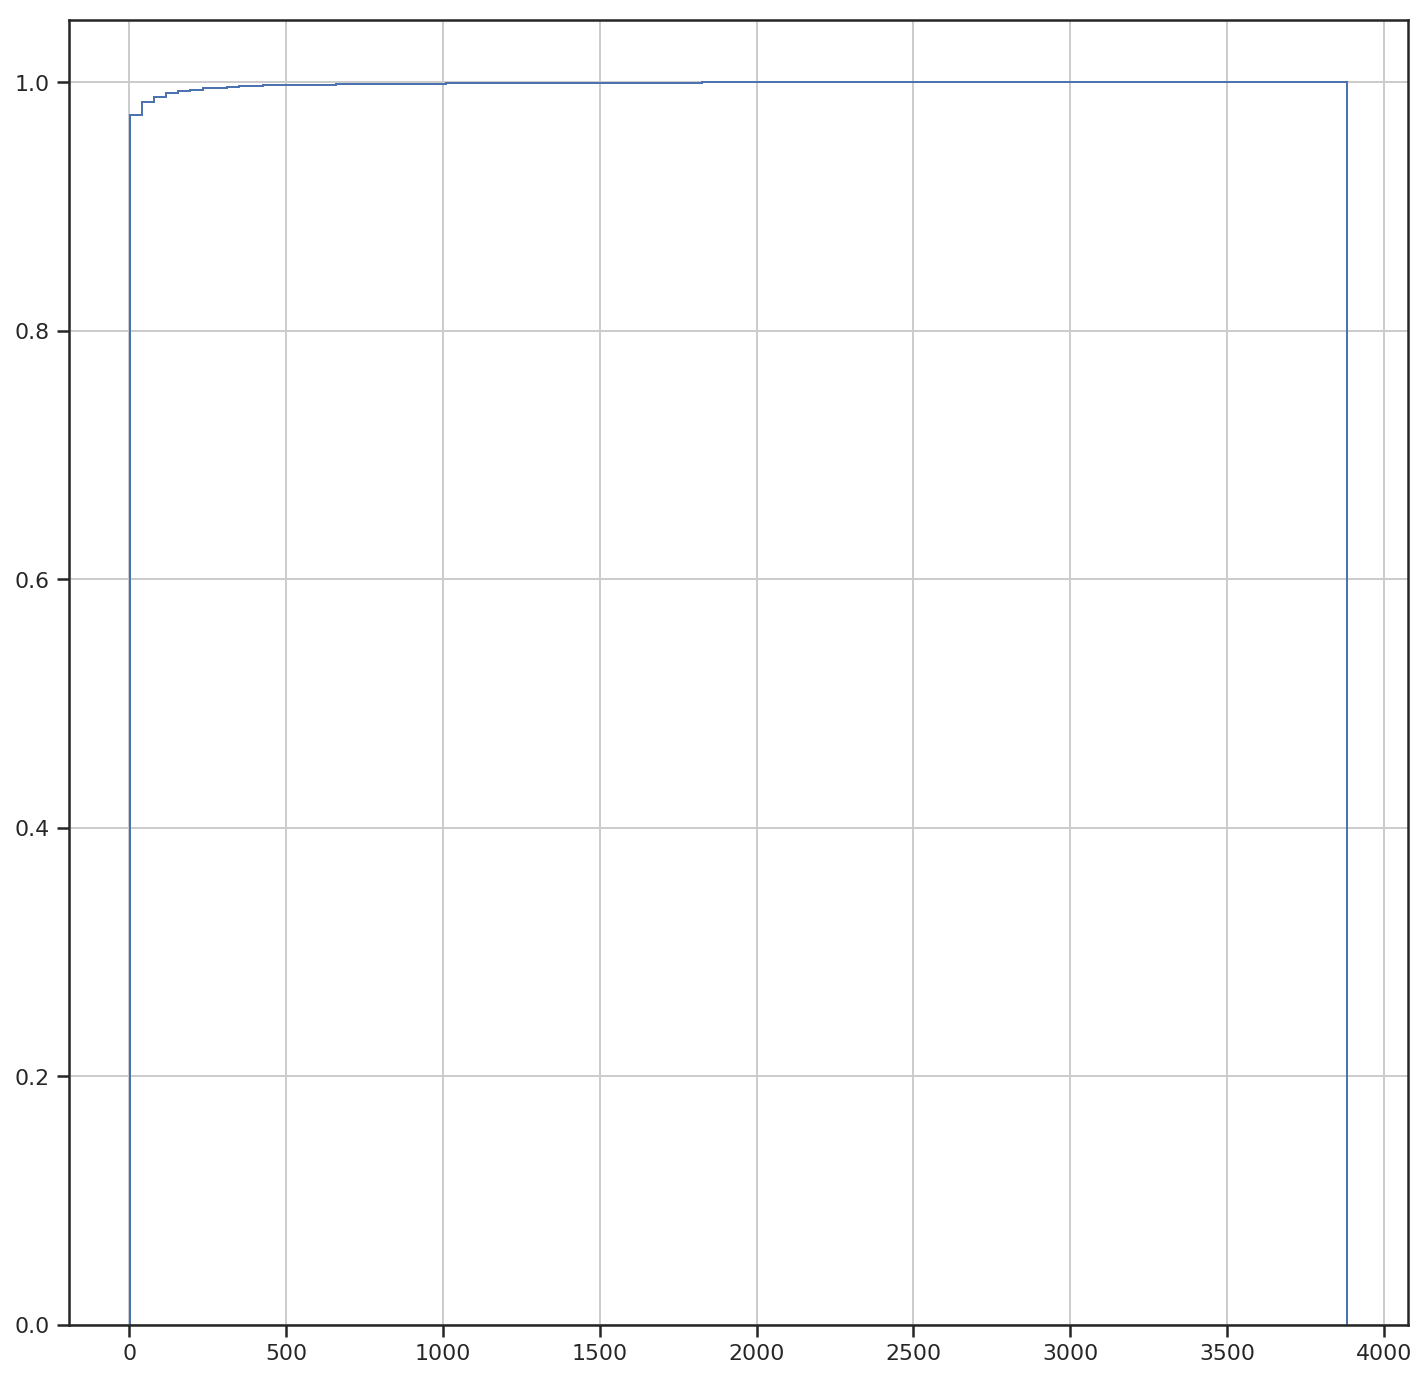

In [44]:
with FigureManager('boink.build-cdbg.SRR1300451.K27/component_sizes_cdf.png',
                   figsize=(12,12),
                   show=True) as (fig, ax):
    
    _samples[26000000].hist(cumulative=True, density=1, bins=100, histtype='step', ax=ax)

/home/camille/miniconda/envs/boink/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  import sys


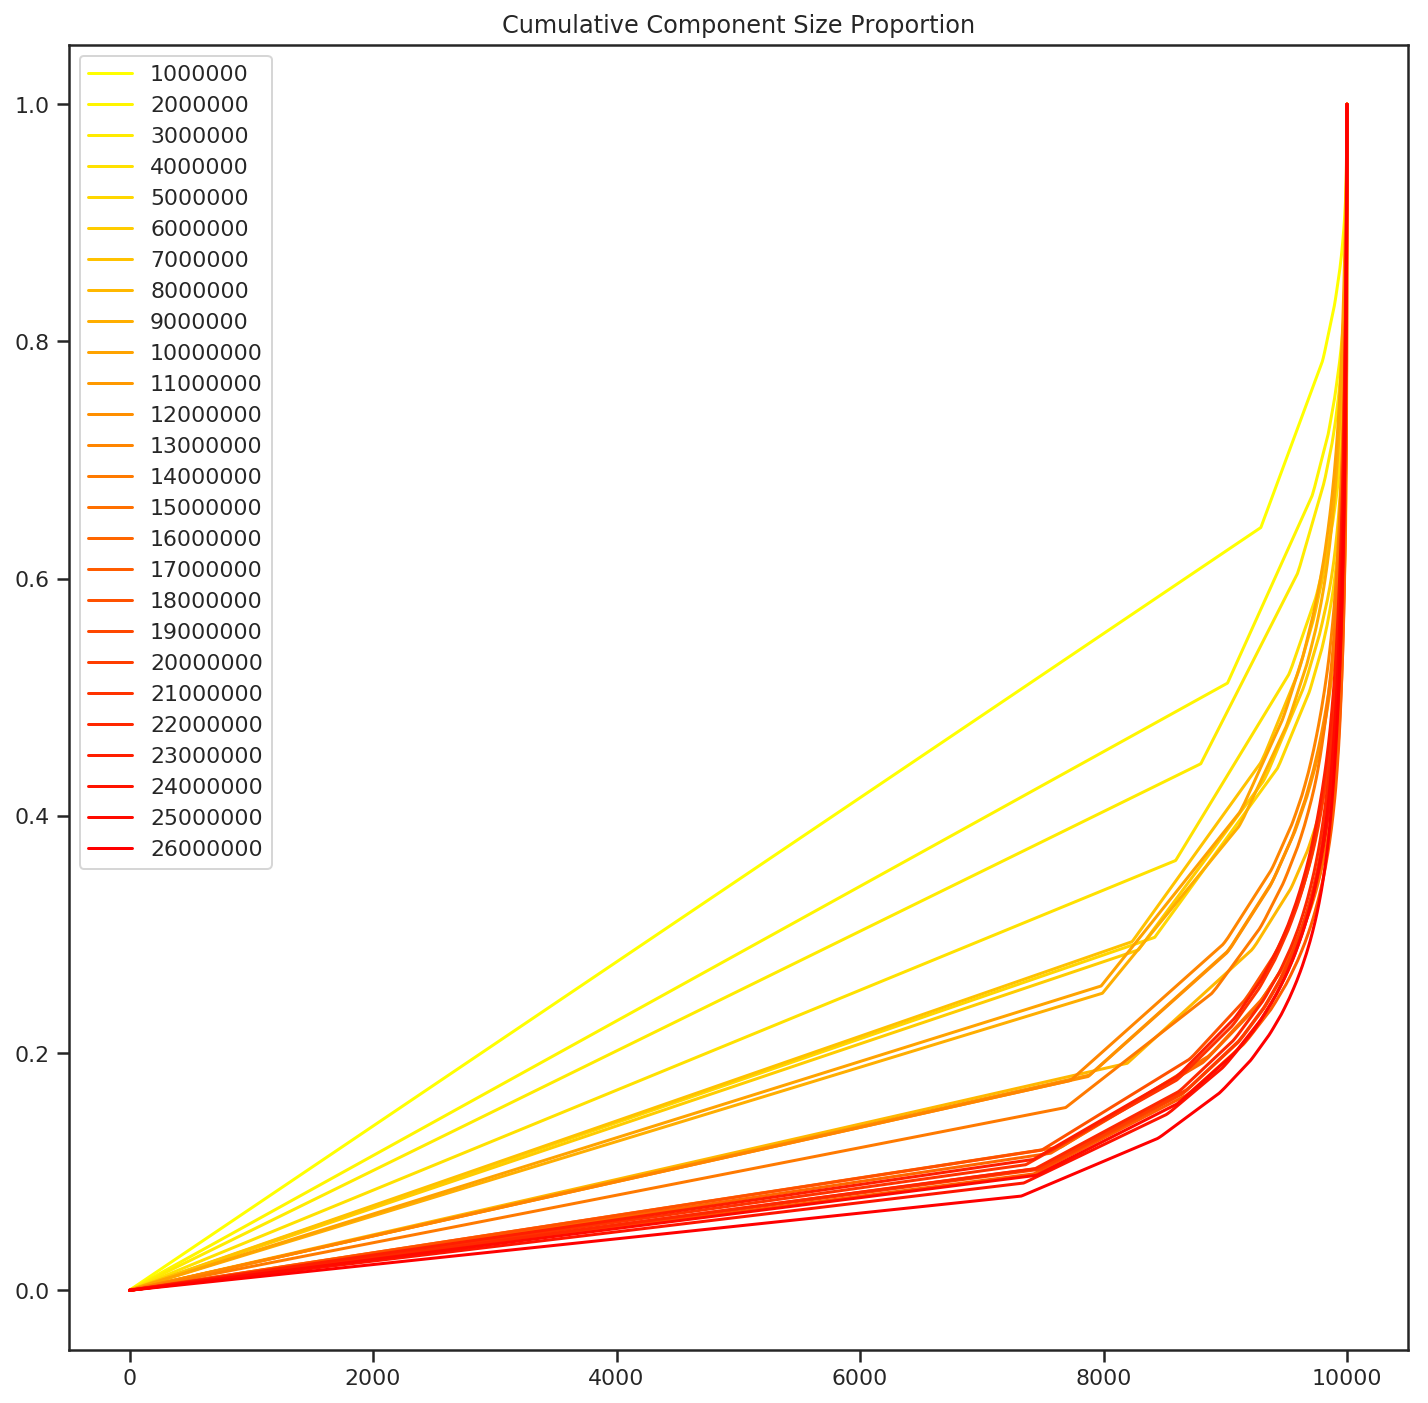

In [15]:
plot_component_size_samples('boink.build-cdbg.SRR1300451.K27')

In [ ]:
plot_component_size_samples('boink.build-cdbg.SRR1300476.K27/')

In [ ]:
plot_component_size_samples('boink.build-cdbg.SRR1300477.K27/')

In [171]:
samples = samples.melt(var_name='sample_t', value_name='size')

In [172]:
samples = samples[samples['size'] < 5000000]#[samples['size'] > 1]

In [173]:
samples['size'] = np.log(samples['size'])

In [ ]:
import joypy

with FigureManager('boink.build-cdbg.SRR1300451.K27/log_component_size_dist_1to100000.png',
                   figsize=(8,16),
                   show=True) as (fig, ax):

    labels=[t if t % 1000000 == 0 else None for t in list(samples.sample_t.unique())]
    _, _ = joypy.joyplot(samples,
                         by="sample_t",
                         column="size",
                         labels=labels,
                         range_style='own', 
                         grid="y",
                         linewidth=1,
                         legend=False,
                         title="cDBG Component Size Distribution as Reads are Added, SRR1300451, K=27",
                         colormap=cm.autumn_r,
                         ax=ax)

/home/camille/miniconda/envs/boink/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


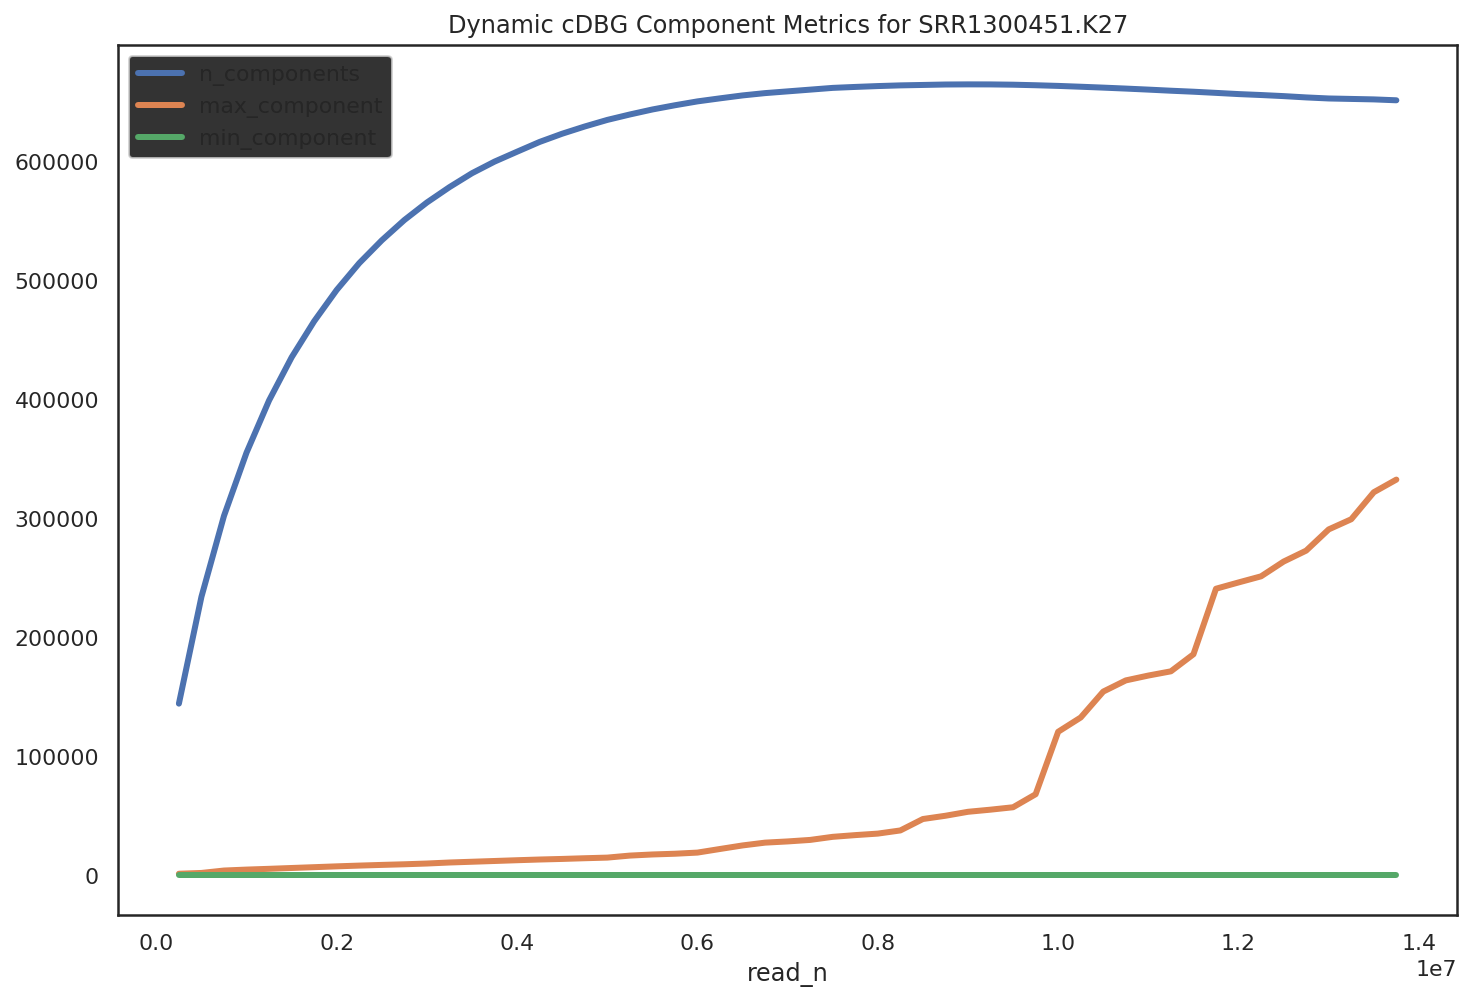

In [129]:
with FigureManager(filename='boink.build-cdbg.SRR1300451.K27/component_metrics.png',
                   figsize=(12,8),
                   show=True) as (fig, ax):
    cols = ['read_n', 'n_components', 'max_component', 'min_component']
    data[cols].plot(x='read_n', lw=3, ax=ax)
    ax.legend()
    ax.set_title('Dynamic cDBG Component Metrics for SRR1300451.K27')

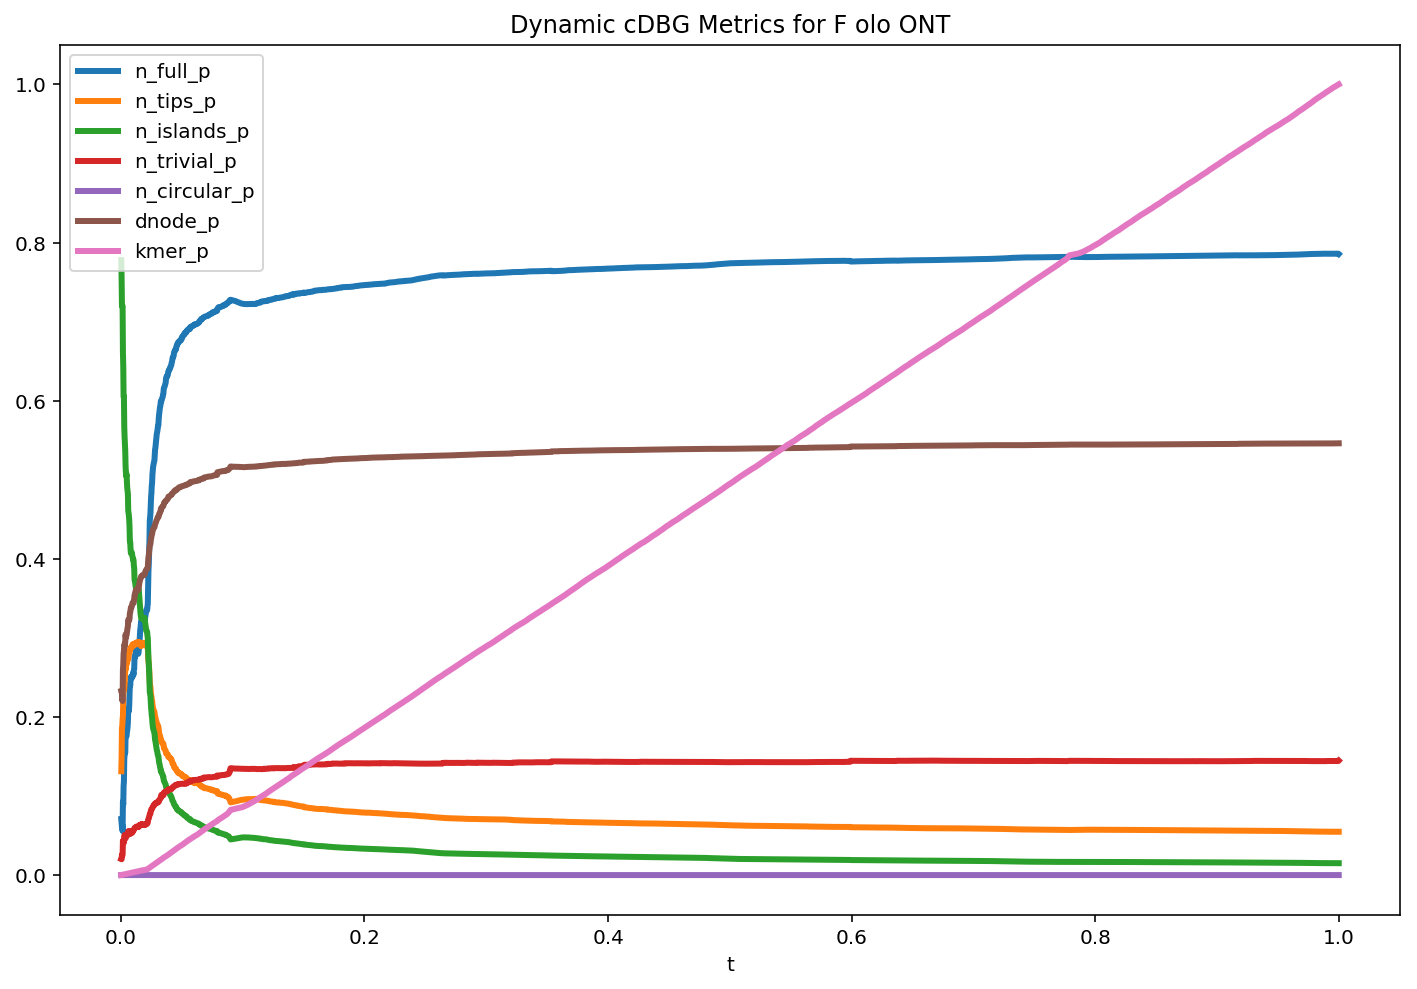

In [93]:
plot_proportional('F_olo.cDBG.K31.stats.csv', 'F olo ONT')

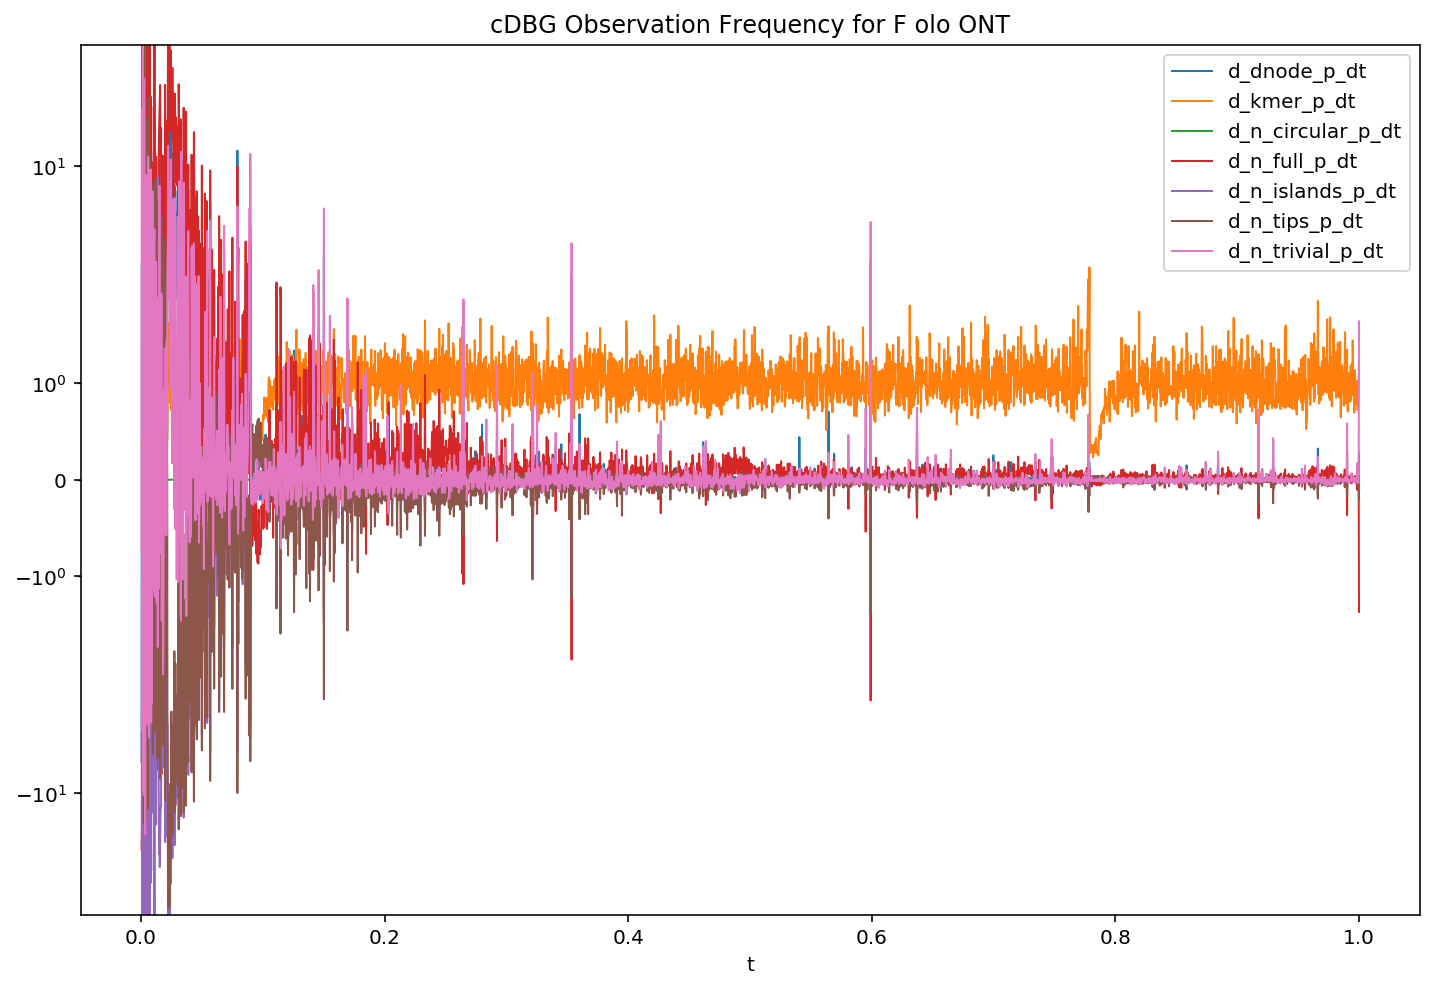

In [111]:
plot_frequency('F_olo.cDBG.K31.stats.csv', 'F olo ONT', ylim=(50,-50), lw=1, logy=True)

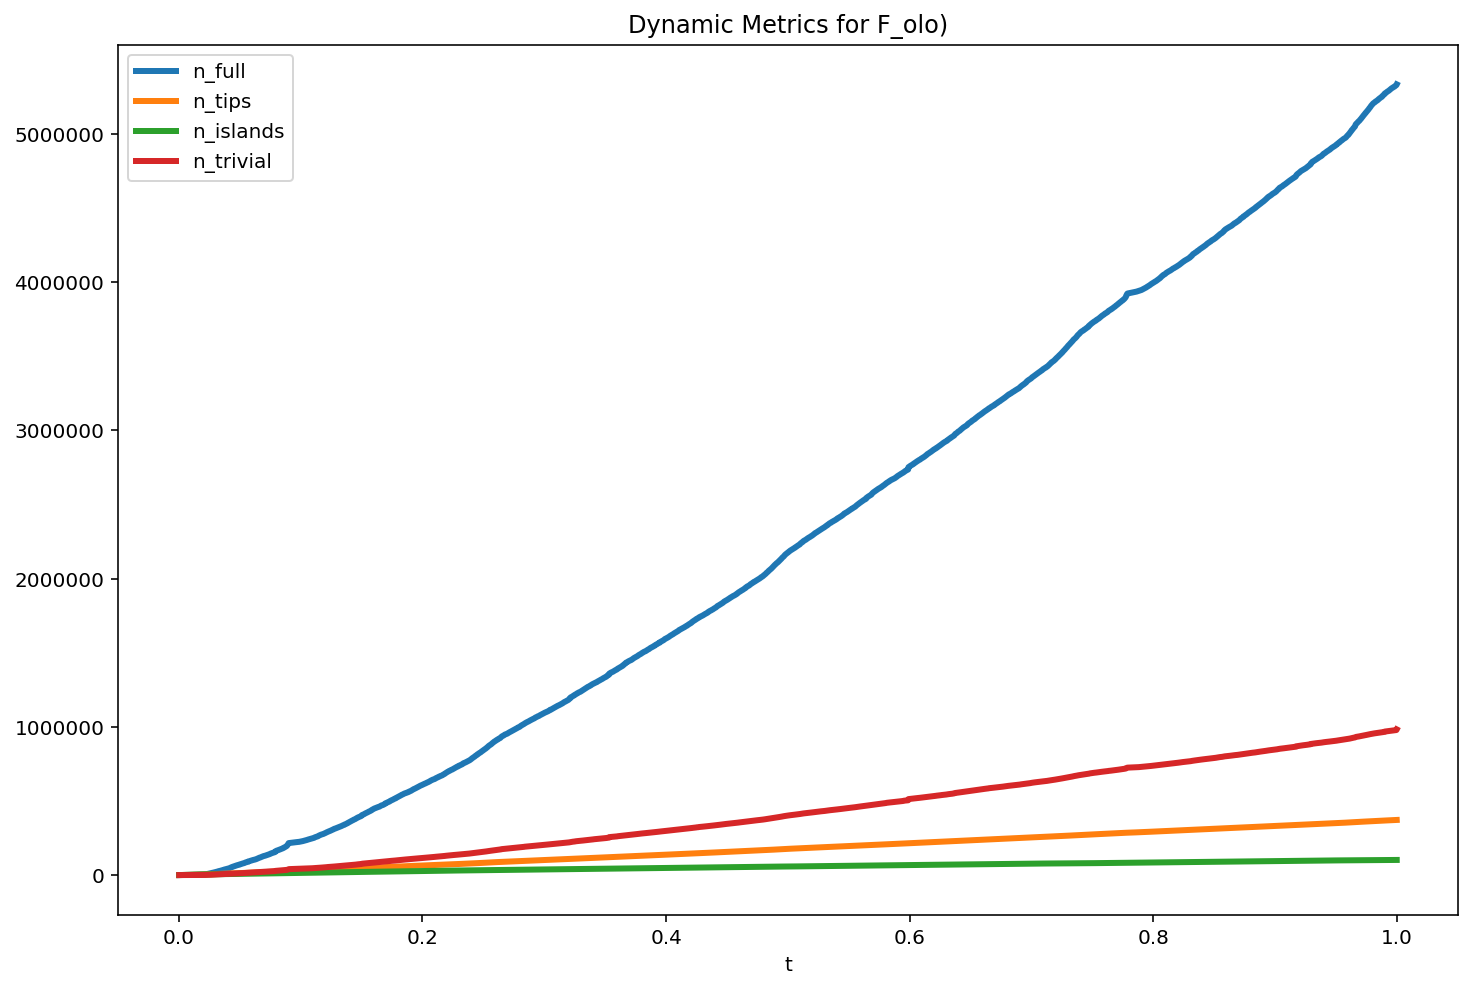

/work/DIB_NIH_Grant_2018/F_olo.cDBG.K31.stats.png

In [66]:
with FigureManager(filename='F_olo.cDBG.K31.stats.png',
                   figsize=(12,8),
                   show=True) as (fig, ax):
    cols = ['t', 'n_full', 'n_tips', 'n_islands', 'n_trivial']
    data[cols].plot(x='t', lw=3, ax=ax)
    ax.legend()
    ax.set_title('Dynamic Metrics for F_olo)')

FileLink('F_olo.cDBG.K31.stats.png')

In [139]:
data = pd.read_csv('2018-11-20-17:34.cdbg.components.csv', index_col=False)

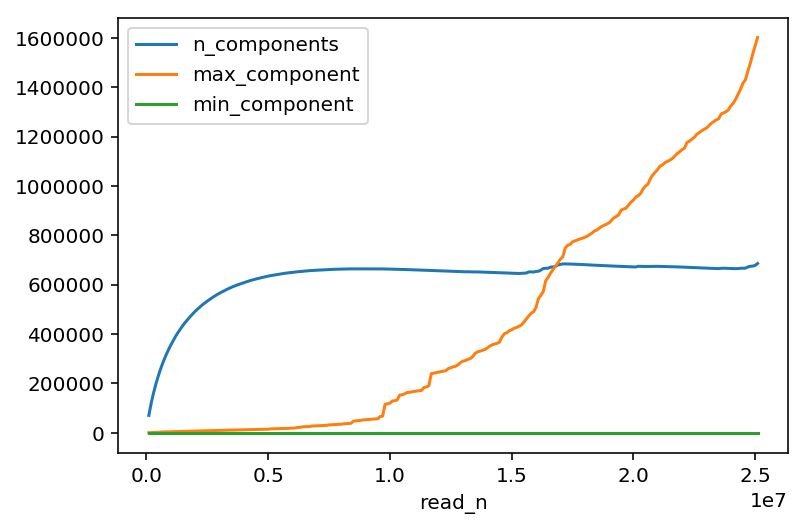

In [140]:
data.plot(x='read_n')